# Trabajo Fashion MNIST



Trabajaremos con el dataset **Fashion MNIST** para aplicar distintos algoritmos (desde los más simples como KNN o árboles, hasta redes neuronales más complejas), haciendo pruebas y comparaciones para quedarnos finalmente con el modelo más eficiente.

En primer lugar importaremos las librerías necesarias:

* numpy: para manejar arrays y datos numéricos
* matplotlib.pyplot: para visualizar imágenes del dataset
* tensorflow.keras.datasets: para cargar directamente el dataset Fashion MNIST
* sklearn.model_selection y preprocessing: para dividir datos en subconjuntos y escalar características en los modelos




In [1]:
# 1. Carga y exploración de los datos
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Cargamos el dataset **Fashion MNIST**, que contiene 70,000 imágenes (28x28 px) de ropa en escala de grises, y al hacerlo, separamos los datos en conjunto de entrenamiento y de prueba

In [2]:
# Cargamos el dataset y separamos los datos
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


A continuación, normalizamos los datos dividiendo entre 255, para que los valores estén en el rango [0, 1]. Esto es importante porque los modelos funcionan mejor con datos pequeños y homogéneos, especialmente las redes neuronales que usan funciones como ReLU o sigmoid.

Esto mejora el rendimiento y la estabilidad de muchos algoritmos de aprendizaje



In [3]:
# Normalizamos los datos
X_train = X_train / 255.0
X_test = X_test / 255.0

Para entender el contenido del dataset y confirmar que las imágenes tienen sentido antes de seguir con el procesamiento de los datos, visualizamos algunas imágenes

Número de imágenes de entrenamiento en Fashion MNIST: 60000
Número de imágenes de prueba en Fashion MNIST: 10000


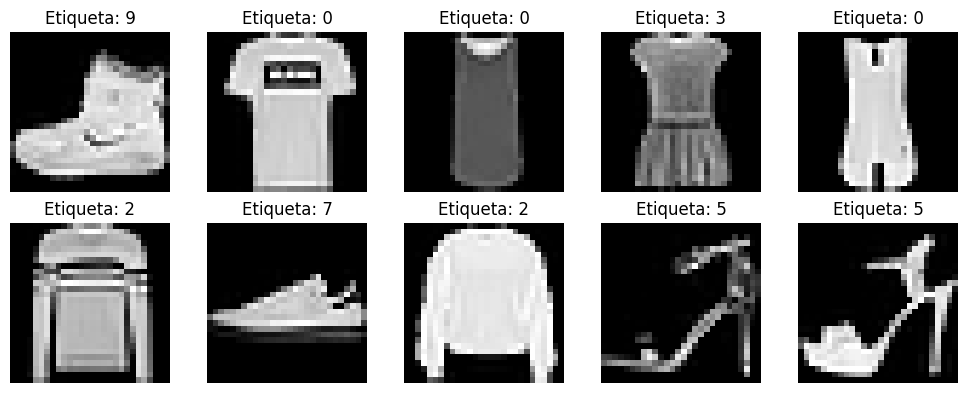

In [4]:
# Mostramos cuántas imágenes hay en total en cada conjunto
num_train_images = X_train.shape[0]
num_test_images = X_test.shape[0]
print("Número de imágenes de entrenamiento en Fashion MNIST:", num_train_images)
print("Número de imágenes de prueba en Fashion MNIST:", num_test_images)


# Visualizamos algunas imágenes
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i], cmap="gray")
    plt.title(f"Etiqueta: {y_train[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

Ahora aplanamos las imágenes de 28×28 a vectores de 784 posiciones, porque modelos como KNN o árboles no trabajan con imágenes en 2D, sino con vectores.

Estandarizamos (con StandardScaler) para que los datos tengan media 0 y desviación estándar 1. Esto se hace especialmente para KNN, porque  este modelo mide distancias entre puntos, y si las escalas de los datos son diferentes, las características más grandes dominan el cálculo.

In [5]:
# Aplanamos las imágenes
X_train_flat = X_train.reshape(-1, 28*28)
X_test_flat = X_test.reshape(-1, 28*28)

# Estandarizamos los datos
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_flat)
X_test_std = scaler.transform(X_test_flat)




---



Comenzaremos a probar el dataset con **K-Nearest Neighbors (KNN)** y los siguientes hiperparámetros:


*   n_neighbors= 3,5,7 Probaremos distintos valores de K (número de vecinos) para ver cuál da mejor resultado, ya que, valores bajos de K como 3, tienden a sobreajustar, mientras que valores altos como 7 pueden subajustar. Elegimos 3, 5 y 7 por ser impares, lo que evita empates, y por ser comunes en datasets de clasificación multiclase.

*   train_size=5000 muestras porque KNN no escala bien con muchos datos, y al usar un subconjunto hace que el entrenamiento sea mucho más rápido sin perder mucha precisión.


K = 5 es el valor con mejor precisión y representa un buen equilibrio entre sensibilidad y generalización con una precisión de **0.8030**

In [6]:
# 2. K-Nearest Neighbors (KNN)
# Cargamos datos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

print("\n--- K-Nearest Neighbors ---")
# Probaremos distintos valores de K
for k in [3, 5, 7]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_std[:5000], y_train[:5000])
    preds = knn.predict(X_test_std)
    print(f"KNN (k={k}) Accuracy: {accuracy_score(y_test, preds):.4f}")


--- K-Nearest Neighbors ---
KNN (k=3) Accuracy: 0.7992
KNN (k=5) Accuracy: 0.8030
KNN (k=7) Accuracy: 0.8002




---



También aplicaremos el método **K-means** para probar a agrupar imágenes similares

*   n_clusters=10 porque sabemos que el dataset tiene 10 clases reales (tipos de ropa). A pesar de que el método del codo sugiere que k=6 es un punto óptimo desde el punto de vista de la inercia, al probarlo, las métricas bajaron ligeramente. Aunque KMeans no usa etiquetas, elegir 10 clusters permite evaluar si encuentra una estructura parecida a las clases reales.

*   n_init=10 porque repite el proceso de inicialización 10 veces con centroides diferentes y se queda con el mejor resultado.

*   random_state=42 porque asegura resultados reproducibles.

*   MinMaxScaler como preprocesamiento porque KMeans es sensible a la escala de los datos, y con este escalado lleva todos los valores al rango [0, 1], evitando que unas características dominen sobre otras.

*   PCA(n_components=50) porque reduce la dimensionalidad de 784 a 50, para acelerar el entrenamiento de KMeans, eliminar ruido y mantener la mayor parte de la varianza útil del dataset.

*   range(2, 11) para k en el método del codo porque queremos probar distintos números de clusters posibles (desde pocos hasta 10) y analizar en qué punto la mejora en la inercia se estabiliza.

*   Adjusted Rand Index (ARI) porque mide la similitud entre los clusters obtenidos y las clases reales, ajustado por azar. Ayuda a evaluar qué tan bien agrupa el modelo sin haber usado las etiquetas.

*   Homogeneity Score porque mide si cada cluster contiene solo elementos de una misma clase.

*   PCA(n_components=2) para visualizar los clusters en 2D porque facilita interpretar visualmente los resultados del clustering, proyectando los datos a dos dimensiones principales.

Aunque los clusters no coinciden perfectamente con las clases reales (ARI = 0.3479), la homogeneidad del 50% sugiere que hay cierta estructura útil.

Visualmente, los clusters muestran zonas distinguibles, pero con solapamientos, lo que es esperable en un dataset complejo y multiclase como Fashion MNIST.

--- Clustering con K-Means ---


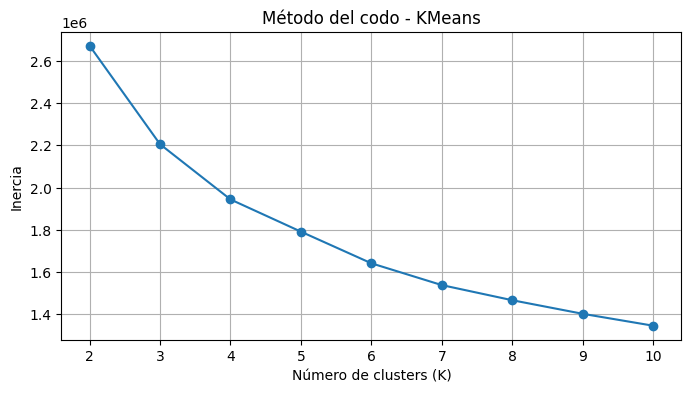

Adjusted Rand Index: 0.3479
Homogeneity Score: 0.5003


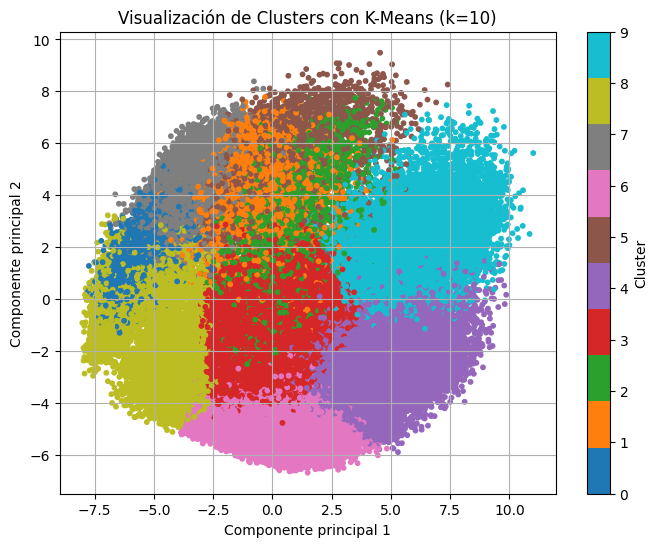

In [9]:
# 3. Clustering no supervisado con K-Means
# Cargamos datos
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, homogeneity_score
from sklearn.decomposition import PCA

print("--- Clustering con K-Means ---")

# Para clustering no usamos etiquetas durante el entrenamiento.
# Aplanamos y estandarizamos las imágenes para aplicar K-Means eficientemente
from sklearn.preprocessing import MinMaxScaler
scaler_kmeans = MinMaxScaler()
X_kmeans = scaler_kmeans.fit_transform(X_train.reshape(-1, 28*28))

# Usamos PCA para reducir a 50 dimensiones
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_kmeans)

# Evaluamos diferentes valores de K para ver cuál minimiza la inercia (método del codo)
inertias = []
ks = range(2, 11)
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_pca)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(ks, inertias, marker='o')
plt.title("Método del codo - KMeans")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Inercia")
plt.grid(True)
plt.show()

# Elegimos K=10 y comparamos con etiquetas verdaderas
kmeans_final = KMeans(n_clusters=10, random_state=42, n_init=10)
kmeans_final.fit(X_pca)
preds_kmeans = kmeans_final.labels_

# Evaluamos qué tan parecidos son los clusters a las clases reales
ari = adjusted_rand_score(y_train, preds_kmeans)
homogeneity = homogeneity_score(y_train, preds_kmeans)
print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Homogeneity Score: {homogeneity:.4f}")

# Visualización de los clusters en 2D
# Aplicamos PCA a 2 componentes principales para poder graficar los datos en 2D
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_kmeans)

plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=preds_kmeans, cmap='tab10', s=10)
plt.title("Visualización de Clusters con K-Means (k=10)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.show()



---



Ahora probaremos con un **Árbol de decisón** y aplicaremos mecanismos de pre poda y post poda

Para la **pre poda** usaremos varios hiperparámetros de pre-poda para limitar el crecimiento del árbol y que no se vuelva demasiado complejo ni sobreeentrene los datos:
*   max_depth=10: Elegimos 10 como profundidad máxima del árbol porque profundidades bajas (<5) pueden subajustar y profundidades muy altas (>15) tienden a sobreajustar, por ello, para un dataset grande y no demasiado complejo como Fashion MNIST, 10 es un valor razonable.
*   min_samples_split=10: Elegimos 10 como el mínimo número de muestras para dividir un nodo porque es número moderado que evita divisiones innecesarias en datasets medianos/grandes.
*   min_samples_leaf=5: Elegimos 5 para controlar que cada hoja debe tener al menos 5 muestras porque es un valor clásico para evitar hojas muy específicas y un sobreajuste.
*   criterion='gini' para evaluar la  calidad de las divisiones.
*   X_train_flat porque el árbol necesita un array 2D plano (no imágenes), por lo tanto se usan las imágenes aplanadas.

Con ello, conseguimos una precisión de **0.8006**


In [ ]:
# 4. Árbol de decisión
# Carga de datos
from sklearn.tree import DecisionTreeClassifier

# Modelo 1: Árbol con pre-poda
clf_tree_pre = DecisionTreeClassifier(max_depth=10, min_samples_split=10, min_samples_leaf=5)
clf_tree_pre.fit(X_train_flat, y_train)
preds_pre = clf_tree_pre.predict(X_test_flat)
print(f"Árbol con pre-poda Accuracy: {accuracy_score(y_test, preds_pre):.4f}")

Árbol con pre-poda Accuracy: 0.8006


Para la **post poda** entrenaremos árboles sin poda, es decir, que no se haya limitado su crecimiento, para que luego, con diferentes hiperparámetros alpha, apliquemos la poda basada en complejidad de coste. Finalmente, compararemos los rendimientos y eligiremos el mejor de ellos.

*  train_test_split(..., test_size=0.2) porque separamos el conjunto de entrenamiento en una parte para entrenar los árboles y otra para validar cuál poda da mejor resultado. El 20% es un valor común para validación sin desperdiciar muchos datos.

*  X_train[:15000] porque se usa una muestra reducida del conjunto de entrenamiento para reducir el tiempo de cálculo, y con una muestra menor de por ejemplo 5000 al tener menos datos con los que poder entrenar, se reduce la capacidad de aprender del modelo y puede disminuir el rendimiento.

*  DecisionTreeClassifier(random_state=0) como árbol base porque necesitamos un modelo estable y reproducible para calcular la ruta de poda.

*  ccp_alphas[:20] porque limitamos el número de árboles a entrenar para acelerar el proceso sin perder demasiada calidad en la evaluación.

*  DecisionTreeClassifier(ccp_alpha=...) porque cada valor de ccp_alpha representa un nivel diferente de poda.
*  random_state=0 en todos los modelos porque queremos consistencia en los resultados cuando se repita el experimento.


Con ello, conseguimos una precisión de **0.7635**

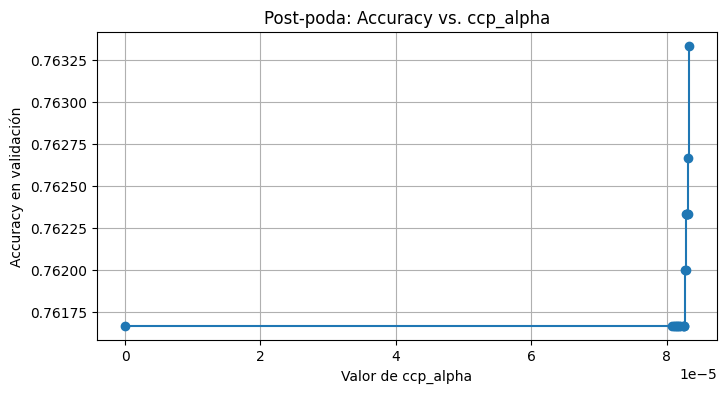

Árbol post-podado final (ccp_alpha=0.00008) Accuracy en test: 0.7635


In [ ]:
# Modelo 2: Árbol con post-poda (ccp_alpha)
from sklearn.model_selection import train_test_split

# Dividimos el conjunto de entrenamiento original (usando solo 15000 muestras para acelerar el proceso)
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(X_train_flat[:15000], y_train[:15000], test_size=0.2, random_state=42)

# Entrenamos un árbol sin poda para obtener los posibles valores de alpha
clf_base = DecisionTreeClassifier(random_state=0)
path = clf_base.cost_complexity_pruning_path(X_train_sub, y_train_sub)
ccp_alphas = path.ccp_alphas[:20]  # Limitamos a los primeros 20 valores para acelerar el proceso

# Entrenamos un árbol para cada valor de alpha generado
arboles_podados = []
for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha)
    clf.fit(X_train_sub, y_train_sub)
    arboles_podados.append(clf)

# Evaluamos el accuracy de cada árbol usando el conjunto de validación
val_accuracies = [accuracy_score(y_val_sub, clf.predict(X_val_sub)) for clf in arboles_podados]

# Mostramos los resultados en una gráfica
plt.figure(figsize=(8, 4))
plt.plot(ccp_alphas, val_accuracies, marker='o', drawstyle="steps-post")
plt.xlabel("Valor de ccp_alpha")
plt.ylabel("Accuracy en validación")
plt.title("Post-poda: Accuracy vs. ccp_alpha")
plt.grid(True)
plt.show()

# Elegimos el árbol con mejor accuracy en validación
indice_mejor = np.argmax(val_accuracies)
mejor_arbol = arboles_podados[indice_mejor]

# Evaluamos este árbol final en el conjunto de test
final_preds = mejor_arbol.predict(X_test_flat)
print(f"Árbol post-podado final (ccp_alpha={ccp_alphas[indice_mejor]:.5f}) Accuracy en test: {accuracy_score(y_test, final_preds):.4f}")



---





Ahora probaremos con **bosques aleatorios** y utilizaremos los siguientes hiperparámetros:
*   n_estimators=200 porque auque en la práctica 100 es el número habitual de árboles en el bosque, aumentándolo a 200 puede mejorar la estabilidad del modelo.
*   criterion="gini" se usa porque es una medida eficiente y común para evaluar la calidad de las divisiones.
*    max_features="sqrt" introduce aleatoriedad al seleccionar solo una raíz cuadrada del total de características en cada división, reduciendo la correlación entre árboles y mejorando la generalización.
*   Con bootstrap=True y max_samples=2/3, simulamos el muestreo con reemplazo clásico del método, asegurando que cada árbol vea un subconjunto distinto de los datos, aumentando la diversidad.
*   oob_score=True permite estimar la precisión del modelo sin usar un conjunto de validación adicional, aprovechando las muestras no utilizadas en cada árbol (out-of-bag).
*   max_depth=15 porque es un valor razonable para limitar la complejidad de cada árbol y evitar el sobreajuste en un dataset como Fashion MNIST con 784 características
*   random_state=42 porque es el número convencional para fijar la semilla del generador aleatorio que usa el modelo

Con este modelo de bosques aleatorios se ha conseguido una precisión de **0,8655** y una estimación de out of the bag de **0.8749** que muestra una capacidad de generalización adecuada sin necesidad de un conjunto de validación adicional.

In [ ]:
# 5. Random Forest
from sklearn.ensemble import RandomForestClassifier

print("\n--- Random Forest ---")
# Creamos el modelo con los hiperparámetros seleccionados
rf = RandomForestClassifier(
    n_estimators=200,
    criterion="gini",
    max_features="sqrt",
    bootstrap=True,
    max_samples=2/3,
    oob_score=True,
    max_depth=15,
    random_state=42
)

# Entrenamos con los datos de entrenamiento ya aplanados
rf.fit(X_train_flat, y_train)

# Predicción sobre los datos de prueba
preds_rf = rf.predict(X_test_flat)

# Evaluamos el rendimiento
print(f"Random Forest Accuracy: {accuracy_score(y_test, preds_rf):.4f}")
print(f"OOB Score (estimación sin conjunto de validación): {rf.oob_score_:.4f}")



--- Random Forest ---
Random Forest Accuracy: 0.8667
OOB Score (estimación sin conjunto de validación): 0.8764




---



A continuación probaremos con un modelo de **redes neuronales multicapa** y  los siguientes hiperparámetros:
*   Dense(256) porque es una capa con alta capacidad para capturar patrones complejos al inicio del modelo.
*   Dense(128) porque reduce gradualmente la dimensionalidad, manteniendo capacidad de representación.
*    Dense(64) porque sigue afinando la representación antes de la salida, sin ser tan costoso computacionalmente.
*   activation='relu' porque es una función no lineal eficiente que evita problemas como el desvanecimiento del gradiente.
*   Dropout(0.3) porque apaga aleatoriamente un 30% de las neuronas durante el entrenamiento, lo cual reduce el sobreajuste.
*   epochs=20 porque permite entrenar lo suficiente para que el modelo aprenda bien sin alargar el tiempo innecesariamente.
*   batch_size=64 porque mejora la estabilidad del entrenamiento al actualizar pesos más frecuentemente que con 128 o más.
*   validation_split=0.1 porque usamos un 10% del conjunto de entrenamiento para validar, sin necesidad de un conjunto de validación externo.
*   EarlyStopping(patience=3) porque evita entrenar más de la cuenta deteniendo el proceso si no mejora tras 3 épocas seguidas.
*   optimizer='adam' porque es un optimizador rápido y confiable para la mayoría de los problemas con redes neuronales.
*   loss='categorical_crossentropy' porque es la función estándar para clasificación multiclase.

Con esto se ha alcanzado una precisión de **0.8833**

In [ ]:
# 6. Red neuronal simple (MLP)
# Cargamos los datos
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Convertimos las imágenes en vectores de entrada adecuados para la red neuronal.
X_train_mlp = X_train.reshape(-1, 28*28)
X_test_mlp = X_test.reshape(-1, 28*28)
#Convertimos las etiquetas en una forma que la red pueda interpretar para clasificación multiclase.
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

print("--- Red Neuronal (MLP) ---")

# - Tres capas ocultas con más neuronas: 256, 128, 64
# - Dropout del 30% entre capas para reducir el sobreajuste
# - EarlyStopping para cortar el entrenamiento si no mejora la validación
mlp = Sequential([
    Dense(256, activation='relu', input_shape=(784,)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

# Compilamos el modelo con el optimizador Adam
mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# EarlyStopping monitoriza la pérdida en validación y detiene el entrenamiento si no mejora en 3 épocas
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenamos el modelo con más épocas y menor batch size para mejorar el aprendizaje
mlp.fit(X_train_mlp, y_train_cat,
        epochs=20,
        batch_size=64,
        validation_split=0.1,  # Usamos el 10% del entrenamiento para validación
        callbacks=[early_stop],
        verbose=0)

# Evaluamos en el conjunto de test
loss, acc = mlp.evaluate(X_test_mlp, y_test_cat, verbose=0)
print(f"MLP Accuracy: {acc:.4f}")

--- Red Neuronal (MLP) ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MLP Accuracy: 0.8833




---



A continuación probaremos con un modelo de **redes neuronales convoluvionales** y los siguientes hiperparámetros:

* Conv2D(32, (3, 3), padding='same') porque 32 filtros pequeños captan bordes y detalles locales desde el inicio, con padding para no perder resolución.

* Conv2D(64, (3, 3), padding='same') porque al aumentar los filtros se detectan patrones más complejos y generalizables.

* activation='relu' porque es eficiente y evita problemas como el desvanecimiento del gradiente.

* MaxPooling2D((2, 2)) porque reduce el tamaño de las representaciones y ayuda a que el modelo se enfoque en lo más importante.

* Dropout(0.25) entre capas convolucionales porque reduce el riesgo de sobreajuste sin afectar mucho la capacidad de aprendizaje.

* Flatten() porque convierte el mapa de características en un vector plano para conectarlo con la capa densa final.

* Dense(128) porque aporta capacidad de clasificación sin ser tan costosa como capas más grandes.

* Dropout(0.5) después de la capa densa porque ayuda a evitar el sobreajuste, especialmente en etapas finales.

* Dense(10, activation='softmax') porque es la salida clásica para clasificación multiclase con 10 clases.

* optimizer='adam' porque es eficiente y se adapta dinámicamente a la escala de los gradientes.

* loss='categorical_crossentropy' porque es la función estándar para clasificación con etiquetas multiclase.

* epochs=20 porque permite al modelo entrenar lo suficiente, pero sin riesgo de sobreentrenamiento gracias a EarlyStopping.

* batch_size=64 porque permite actualizaciones más frecuentes del gradiente, haciendo el entrenamiento más sensible.

* validation_split=0.1 porque reservar un 10% del conjunto de entrenamiento para validación es suficiente para monitorear el rendimiento.

* EarlyStopping(patience=3) porque evita entrenar de más si el modelo no mejora durante 3 épocas consecutivas.

Con este modelo hemos obtenido una precisión de **0.9197**

In [ ]:
# 7. Red neuronal convolucional (CNN)
# Cargamos datos
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

print("--- Red Neuronal Convolucional (CNN) ---")

# Preparamos los datos dándoles la forma esperada por una CNN: (28, 28, 1)
X_train_cnn = X_train.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.reshape(-1, 28, 28, 1)

# Modelo CNN optimizado:
# - Más filtros para captar mejor los patrones visuales.
# - Capas Dropout para evitar sobreajuste.
# - EarlyStopping para evitar entrenar de más.
cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),  # Captura bordes y detalles locales
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Más filtros, misma técnica de padding
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),  # Aumentamos la capa densa a 128 neuronas
    Dropout(0.5),
    Dense(10, activation='softmax')
])

cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop_cnn = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

cnn.fit(X_train_cnn, y_train_cat,
        epochs=20,
        batch_size=64,
        validation_split=0.1,
        callbacks=[early_stop_cnn],
        verbose=0)

loss, acc = cnn.evaluate(X_test_cnn, y_test_cat, verbose=0)
print(f"CNN Optimizada Accuracy: {acc:.4f}")

--- Red Neuronal Convolucional (CNN) ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


CNN Optimizada Accuracy: 0.9197




---



In [10]:
# 8. Comparación final de modelos
import pandas as pd

# Creamos una tabla con los resultados conocidos
resultados = pd.DataFrame({
    'Modelo': [
        'K-Nearest Neighbors (k=5)',
        'Árbol de Decisión (pre-poda)',
        'Árbol de Decisión (post-poda)',
        'Random Forest',
        'Red Neuronal Simple (MLP)',
        'Red Neuronal Convolucional (CNN)',
        'K-Means (ARI/Homogeneity)'
    ],
    'Precisión / Métrica': [
        '0.8030',
        '0.8006',
        '0.7635',
        '0,8655',
        '0.8833',
        '0.9197',
        'ARI: 0.3479 / Hom: 0.50'
    ]
})

print("Resumen de resultados de todos los modelos:")
display(resultados)


Resumen de resultados de todos los modelos:


,Modelo,Precisión / Métrica
0,K-Nearest Neighbors (k=5),0.8030
1,Árbol de Decisión (pre-poda),0.8006
2,Árbol de Decisión (post-poda),0.7635
3,Random Forest,"0,8655"
4,Red Neuronal Simple (MLP),0.8833
5,Red Neuronal Convolucional (CNN),0.9197
6,K-Means (ARI/Homogeneity),ARI: 0.3479 / Hom: 0.50


# **Conclusión**:

Tras evaluar todos los modelos, observamos que la **Red Neuronal Convolucional (CNN)** ofrece el mejor rendimiento con una precisión aproximada del 91%, superando al resto tanto en capacidad de generalización como en adaptación al tipo de datos (imágenes).

Aunque requiere más tiempo de entrenamiento, la CNN aprovecha la estructura espacial de las imágenes y aprende patrones más profundos. Por tanto, recomendamos este modelo como el más eficiente y adecuado para resolver el problema de clasificación en Fashion MNIST.